In [1]:
import pyspark
from random import random
from operator import add
 
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("LoadEnergyDataset").master("spark://172.22.0.2:7077").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/07 22:58:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.format("csv").option("header", "true").option("inferschema","true").load("data/owid-energy-data.csv.gz")


In [4]:
df.show(5,70)

24/05/07 22:59:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------+----+--------+----------+----+-----------------------+-----------------------+-----------------------+-------------------+-----------------------+-------------------+------------------+--------------------+---------------------+--------------------+--------------------+--------------------+----------------+--------------------+----------------+--------------------+--------------------+--------------------+---------------+---------------+-----------------+------------------+----------------------+------------------------+----------------------+----------------------+-----------------+--------------+----------------------+----------------------+----------------------+------------------+------------------------+-----------------------+-----------------+-------------------+-------------------+-------------------+---------------+-------------------+---------------+---------------------+-------------------+-------------------+-------------------+--------------+--------------+-

In [5]:
df2 = df.select("country","year","population","electricity_demand").where("country like \'Po%\' AND year >= 2000")


In [6]:
df2.show(5)
df2.printSchema()

+-------+----+----------+------------------+
|country|year|population|electricity_demand|
+-------+----+----------+------------------+
| Poland|2000|  38504432|            136.81|
| Poland|2001|  38662860|            136.99|
| Poland|2002|  38647476|            135.42|
| Poland|2003|  38621536|            139.85|
| Poland|2004|  38596040|            142.97|
+-------+----+----------+------------------+
only showing top 5 rows

root
 |-- country: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- population: long (nullable = true)
 |-- electricity_demand: double (nullable = true)



In [7]:
df_pl = df.select('year','population','electricity_demand').where(("country == 'Poland' AND electricity_demand IS NOT NULL"))
df_pl.show()

+----+----------+------------------+
|year|population|electricity_demand|
+----+----------+------------------+
|1990|  38064252|             133.4|
|1991|  38167388|             130.1|
|1992|  38252284|            126.66|
|1993|  38319300|            129.37|
|1994|  38375464|            130.61|
|1995|  38401980|            134.25|
|1996|  38401408|            138.07|
|1997|  38396120|            138.76|
|1998|  38379992|             137.3|
|1999|  38354952|            135.06|
|2000|  38504432|            136.81|
|2001|  38662860|            136.99|
|2002|  38647476|            135.42|
|2003|  38621536|            139.85|
|2004|  38596040|            142.97|
|2005|  38575912|            143.86|
|2006|  38547180|            149.46|
|2007|  38521868|            153.16|
|2008|  38522884|            153.97|
|2009|  38555288|             148.9|
+----+----------+------------------+
only showing top 20 rows



In [8]:
import matplotlib.pyplot as plt
df_pl = df_pl.orderBy('year')
y = df_pl.select('year').rdd.flatMap(lambda x: x).collect()
pop = df_pl.select('population').rdd.flatMap(lambda x: x).collect()
dem = df_pl.select('electricity_demand').rdd.flatMap(lambda x: x).collect()

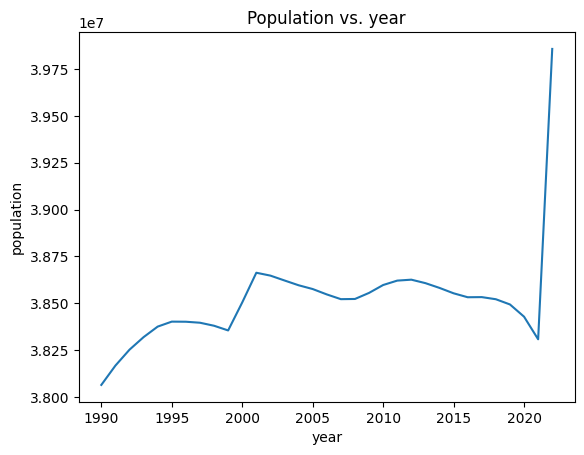

In [9]:
plt.plot(y,pop)
plt.xlabel('year')
plt.ylabel('population')
plt.title('Population vs. year')
plt.show()

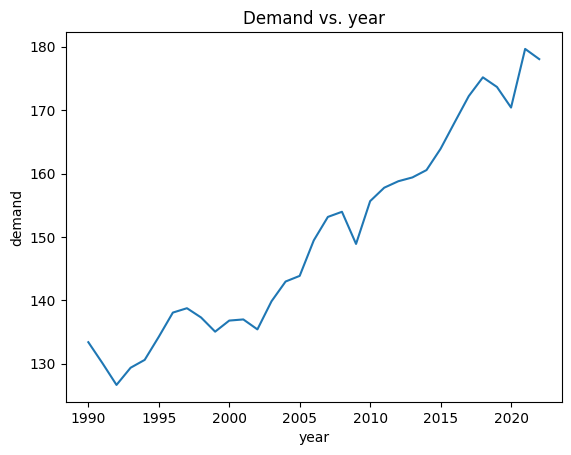

In [10]:
plt.plot(y,dem,label='demand')
plt.xlabel('year')
plt.ylabel('demand')
plt.title('Demand vs. year')
plt.show()

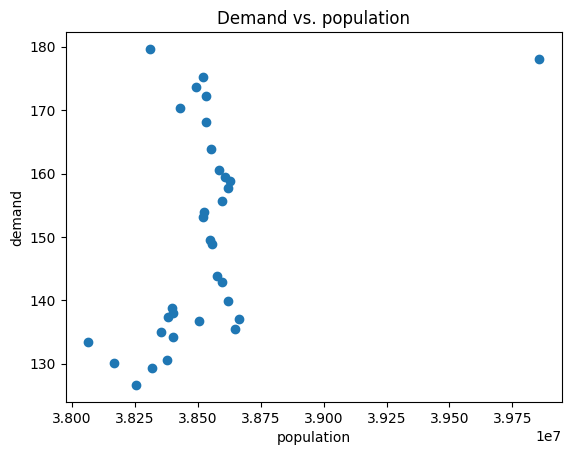

In [11]:
plt.scatter(pop,dem)
plt.xlabel('population')
plt.ylabel('demand')
plt.title('Demand vs. population')
plt.show()

In [12]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
 
va=VectorAssembler().setInputCols(["year"]).setOutputCol("features")
df_plf = va.transform(df_pl)
df_plf.show(5)
 
lr = LinearRegression()\
  .setMaxIter(10)\
  .setRegParam(3.0)\
  .setElasticNetParam(0.5)\
  .setFeaturesCol("features")\
  .setLabelCol("electricity_demand")
model = lr.fit(df_plf)

+----+----------+------------------+--------+
|year|population|electricity_demand|features|
+----+----------+------------------+--------+
|1990|  38064252|             133.4|[1990.0]|
|1991|  38167388|             130.1|[1991.0]|
|1992|  38252284|            126.66|[1992.0]|
|1993|  38319300|            129.37|[1993.0]|
|1994|  38375464|            130.61|[1994.0]|
+----+----------+------------------+--------+
only showing top 5 rows



24/05/07 23:38:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/07 23:38:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [13]:
print(f'RMSE: {model.summary.rootMeanSquaredError}')
print(f'r2: {model.summary.r2}')
print(f'iterations: {model.summary.totalIterations}')
print(f'demand = {model.coefficients}*year {"+" if model.intercept > 0 else ""} {model.intercept}')

RMSE: 4.639977833633796
r2: 0.9149406867055572
iterations: 2
demand = [1.3393788382606018]*year  -2536.8454647022827


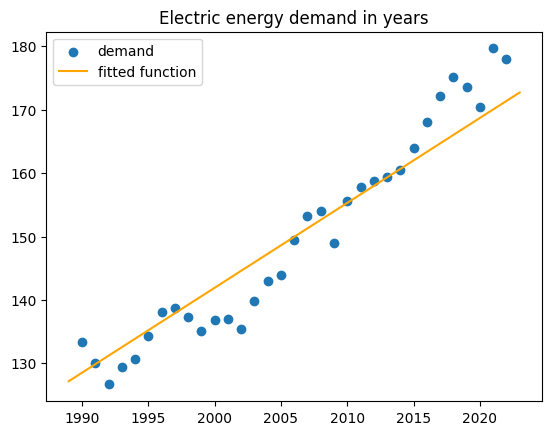

In [14]:
import numpy as np
# from pyspark.sql.types import StructType, StructField, DoubleType
from pyspark.ml.linalg import Vectors
 
xmin = np.min(y)
xmax = np.max(y)
xx = np.linspace(xmin-1,xmax+1,100)
 
yy = [model.predict(Vectors.dense([x])) for x in xx]
 
plt.scatter(y,dem,label='demand')
plt.plot(xx,yy,label='fitted function',c='orange')
plt.legend()
plt.title('Electric energy demand in years')
plt.show()

In [15]:
spark.stop()
